In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# Ignore Warnings
warnings.filterwarnings("ignore")



/Users/wenwei/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load Data
df = pd.read_csv("cleaned data/cleaned_data_split.csv")

In [3]:
ae_cols = ['default_profile', 'default_profile_image',
        'geo_enabled', 'lang', 'location', 'verified',
        'account_age_days', 'is_description_na', 'is_lang_na', 'is_lang_en',
       'is_location_unknown', 'creation_hour', 'creation_day_of_week', 'deviation_from_humans',
       'creation_month', 'creation_year', 'is_weekend', 'creation_quarter',
       'part_of_day', 'creation_week_of_year', 'is_beginning_of_month',
       'is_end_of_month', 'description_length', 'influencer_type',
       'favourites_per_day', 'favourites_activity',
       'mention_count', 'log_favourites_count', 'log_followers_count', 'log_friends_count',
       'log_statuses_count', 'log_average_tweets_per_day',
       'log_fol_to_friends_ratio', 'log_fol_to_tweets_ratio',
       'log_friends_to_tweets_ratio']

# # Outlier Detection and Interpretation with K-Means, Autoencoder, and Decision Tree

This analysis combines clustering, autoencoding, and a surrogate model to identify and explain outliers in the dataset. Below is a step-by-step breakdown of the process:

### 1. Clustering with K-Means
- **K-Means Clustering**: A K-Means model with 10 clusters is trained on the scaled features to group similar data points.
- **Cluster-Based Outlier Detection**: Small clusters (defined as clusters containing less than 5% of the dataset) are flagged as outliers, assuming that infrequent clusters may represent atypical observations.
  
### 2. Autoencoder for Reconstruction-Based Outlier Detection
- **Autoencoder Architecture**: A simple neural network autoencoder is created with:
  - An **input layer** matching the feature dimensions.
  - An **encoding layer** with 4 nodes to capture essential information.
  - A **decoding layer** that reconstructs the input dimensions.
- **Training on Normal Data**: The autoencoder is trained only on data points that were not flagged as outliers by K-Means to learn the normal data distribution.
- **Reconstruction Error Calculation**: For each observation, the reconstruction error is computed. Observations with a reconstruction error above the 95th percentile are flagged as outliers.

### 3. Combined Outlier Flag
- **Final Outlier Label**: An observation is marked as an outlier if it is identified as such by either the K-Means clustering or the autoencoder. The combined flag (`is_outlier`) serves as the target label for further interpretation.

### Summary
This approach leverages both clustering and autoencoding to capture different types of outliers—those that fall into small, distinct groups (via K-Means) and those that deviate from the expected data distribution (via the autoencoder). The Decision Tree surrogate model then provides insight into the characteristics of these outliers.


In [5]:
def standardize_features(df, feature_cols):
    """Standardizes selected features in the DataFrame."""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_cols])
    return X_scaled, scaler


def apply_kmeans_clustering(X_scaled, n_clusters=10, outlier_threshold=0.05):
    """Applies KMeans clustering and identifies outliers based on small cluster sizes."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    cluster_sizes = pd.Series(clusters).value_counts()
    small_clusters = cluster_sizes[cluster_sizes < (outlier_threshold * len(X_scaled))].index
    cluster_outliers = np.isin(clusters, small_clusters).astype(int)
    return clusters, cluster_outliers


def build_autoencoder(input_dim, encoding_dim=4):
    """Defines and compiles an autoencoder model."""
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


def train_autoencoder(autoencoder, X_normal, epochs=50, batch_size=32, validation_split=0.2):
    """Trains the autoencoder on non-outlier data."""
    autoencoder.fit(X_normal, X_normal, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=validation_split)


def calculate_reconstruction_errors(autoencoder, X_scaled):
    """Calculates reconstruction errors for the entire dataset."""
    reconstructions = autoencoder.predict(X_scaled)
    errors = np.mean(np.square(X_scaled - reconstructions), axis=1)
    return errors


def detect_autoencoder_outliers(errors, threshold_percentile=95):
    """Flags observations as outliers based on reconstruction error threshold."""
    threshold = np.percentile(errors, threshold_percentile)
    return (errors > threshold).astype(int)


def combine_outlier_flags(cluster_outliers, autoencoder_outliers):
    """Combines cluster-based and autoencoder-based outlier flags."""
    return np.where((cluster_outliers == 1) | (autoencoder_outliers == 1), 1, 0)


def train_surrogate_model(X, y, max_depth=5):
    """Trains a surrogate decision tree model to interpret the combined outlier detection results."""
    surrogate_model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    surrogate_model.fit(X, y)
    return surrogate_model


# Main Pipeline Function
def detect_outliers_and_interpret(df, feature_cols, kmeans_clusters=10, outlier_threshold=0.05, encoding_dim=4, 
                                  autoencoder_epochs=50, threshold_percentile=95, surrogate_max_depth=5):
    """Executes the entire pipeline for outlier detection and interpretation."""
    
    # Step 1: Standardize Features
    X_scaled, scaler = standardize_features(df, feature_cols)
    
    # Step 2: Apply KMeans Clustering
    clusters, cluster_outliers = apply_kmeans_clustering(X_scaled, n_clusters=kmeans_clusters, outlier_threshold=outlier_threshold)
    df['cluster'] = clusters
    df['is_cluster_outlier'] = cluster_outliers
    
    # Step 3: Build and Train Autoencoder
    autoencoder = build_autoencoder(X_scaled.shape[1], encoding_dim)
    normal_data = X_scaled[cluster_outliers == 0]
    train_autoencoder(autoencoder, normal_data, epochs=autoencoder_epochs)
    
    # Step 4: Calculate Reconstruction Errors and Detect Autoencoder Outliers
    reconstruction_errors = calculate_reconstruction_errors(autoencoder, X_scaled)
    autoencoder_outliers = detect_autoencoder_outliers(reconstruction_errors, threshold_percentile=threshold_percentile)
    df['is_autoencoder_outlier'] = autoencoder_outliers
    
    # Step 5: Combine Outlier Flags
    combined_outliers = combine_outlier_flags(cluster_outliers, autoencoder_outliers)
    df['is_outlier'] = combined_outliers
    
    # Step 6: Train Surrogate Model
    X_surrogate = df[feature_cols]
    y_surrogate = df['is_outlier']
    surrogate_model = train_surrogate_model(X_surrogate, y_surrogate, max_depth=surrogate_max_depth)
    
    return df, scaler, autoencoder, surrogate_model


## Running K-means and AutoEncoder

In [6]:
# Define the columns you want to analyze
feature_cols = ae_cols  # Assuming ae_cols is already defined with the relevant feature columns

# Call the main pipeline function
df_outliers, scaler, autoencoder, surrogate_model = detect_outliers_and_interpret(
    df=df,                    
    feature_cols=feature_cols,
    kmeans_clusters=10,       
    outlier_threshold=0.05,   
    encoding_dim=4,           
    autoencoder_epochs=50,    
    threshold_percentile=95,  
    surrogate_max_depth=5     
)

# Check results
print(df_outliers[['cluster', 'is_cluster_outlier', 'is_autoencoder_outlier', 'is_outlier']].head())
print("Scaler:", scaler)
print("Autoencoder Summary:", autoencoder.summary())
print("Surrogate Model Depth:", surrogate_model.get_depth())


Epoch 1/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - loss: 1.0011 - val_loss: 0.8871
Epoch 2/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 0.7481 - val_loss: 0.8640
Epoch 3/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 0.7464 - val_loss: 0.8504
Epoch 4/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 0.7201 - val_loss: 0.8406
Epoch 5/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 0.7085 - val_loss: 0.8283
Epoch 6/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 0.6935 - val_loss: 0.8176
Epoch 7/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 0.6822 - val_loss: 0.8108
Epoch 8/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 0.6762 - val_loss: 0.8052
Epoch 9/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 0.6755 - val_loss: 0.7997
Epoch 10/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 0.6762 - val_loss: 0.7970
Epoch 11/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.6710 - val_loss: 0.7934
Epoch 12/50
890/890 ━━━━━━━━━━

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 35)             │           175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 959 (3.75 KB)

 Trainable params: 319 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 640 (2.50 KB)

Autoencoder Summary: None
Surrogate Model Depth: 5


### Surrogate Model for Interpretation
- **Decision Tree Classifier**: To interpret the results, a Decision Tree Classifier is trained on the full dataset, with `is_outlier` as the target label. This provides a rule-based, interpretable model that helps understand feature importance and patterns associated with outliers.


In [7]:
def analyze_decision_tree(model, X, feature_names, output_dict=False):
    """
    Comprehensive analysis of the decision tree model
    """
    # 1. Feature Importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # 2. Get decision rules as text
    tree_rules = export_text(model, feature_names=list(feature_names))
    
    # 3. Calculate feature threshold statistics
    feature_thresholds = {}
    n_nodes = model.tree_.node_count
    features = model.tree_.feature
    thresholds = model.tree_.threshold
    
    for i in range(n_nodes):
        if features[i] != -2:  # Not a leaf node
            feature_name = feature_names[features[i]]
            if feature_name not in feature_thresholds:
                feature_thresholds[feature_name] = []
            feature_thresholds[feature_name].append(thresholds[i])
    
    threshold_stats = {
        feature: {
            'mean': np.mean(values),
            'min': np.min(values),
            'max': np.max(values),
            'count': len(values)
        }
        for feature, values in feature_thresholds.items()
    }
    
    # 4. Get node statistics
    node_stats = {
        'total_nodes': model.tree_.node_count,
        'leaf_nodes': model.get_n_leaves(),
        'max_depth': model.get_depth()
    }
    
    if output_dict:
        return {
            'feature_importance': importance_df,
            'tree_rules': tree_rules,
            'threshold_stats': threshold_stats,
            'node_stats': node_stats
        }
    
    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. Feature Importance Plot
    plt.subplot(2, 1, 1)
    sns.barplot(data=importance_df, x='importance', y='feature')
    plt.title('Feature Importance in Decision Tree')
    plt.xlabel('Importance Score')
    
    # 2. Decision Tree Visualization
    plt.subplot(2, 1, 2)
    plot_tree(model, feature_names=list(feature_names), 
             class_names=['Normal', 'Outlier'],
             filled=True, rounded=True)
    plt.title('Decision Tree Structure')
    
    plt.tight_layout()
    plt.show()
    
    # Print text-based analysis
    print("\nDecision Tree Analysis:")
    print("=" * 50)
    print("\n1. Node Statistics:")
    for key, value in node_stats.items():
        print(f"{key}: {value}")
    
    print("\n2. Feature Threshold Statistics:")
    for feature, stats in threshold_stats.items():
        if stats['count'] > 0:  # Only show features actually used in the tree
            print(f"\n{feature}:")
            for stat_name, stat_value in stats.items():
                print(f"  {stat_name}: {stat_value:.2f}" if isinstance(stat_value, float) 
                      else f"  {stat_name}: {stat_value}")
    
    print("\n3. Decision Rules:")
    print(tree_rules)



# Model Performance

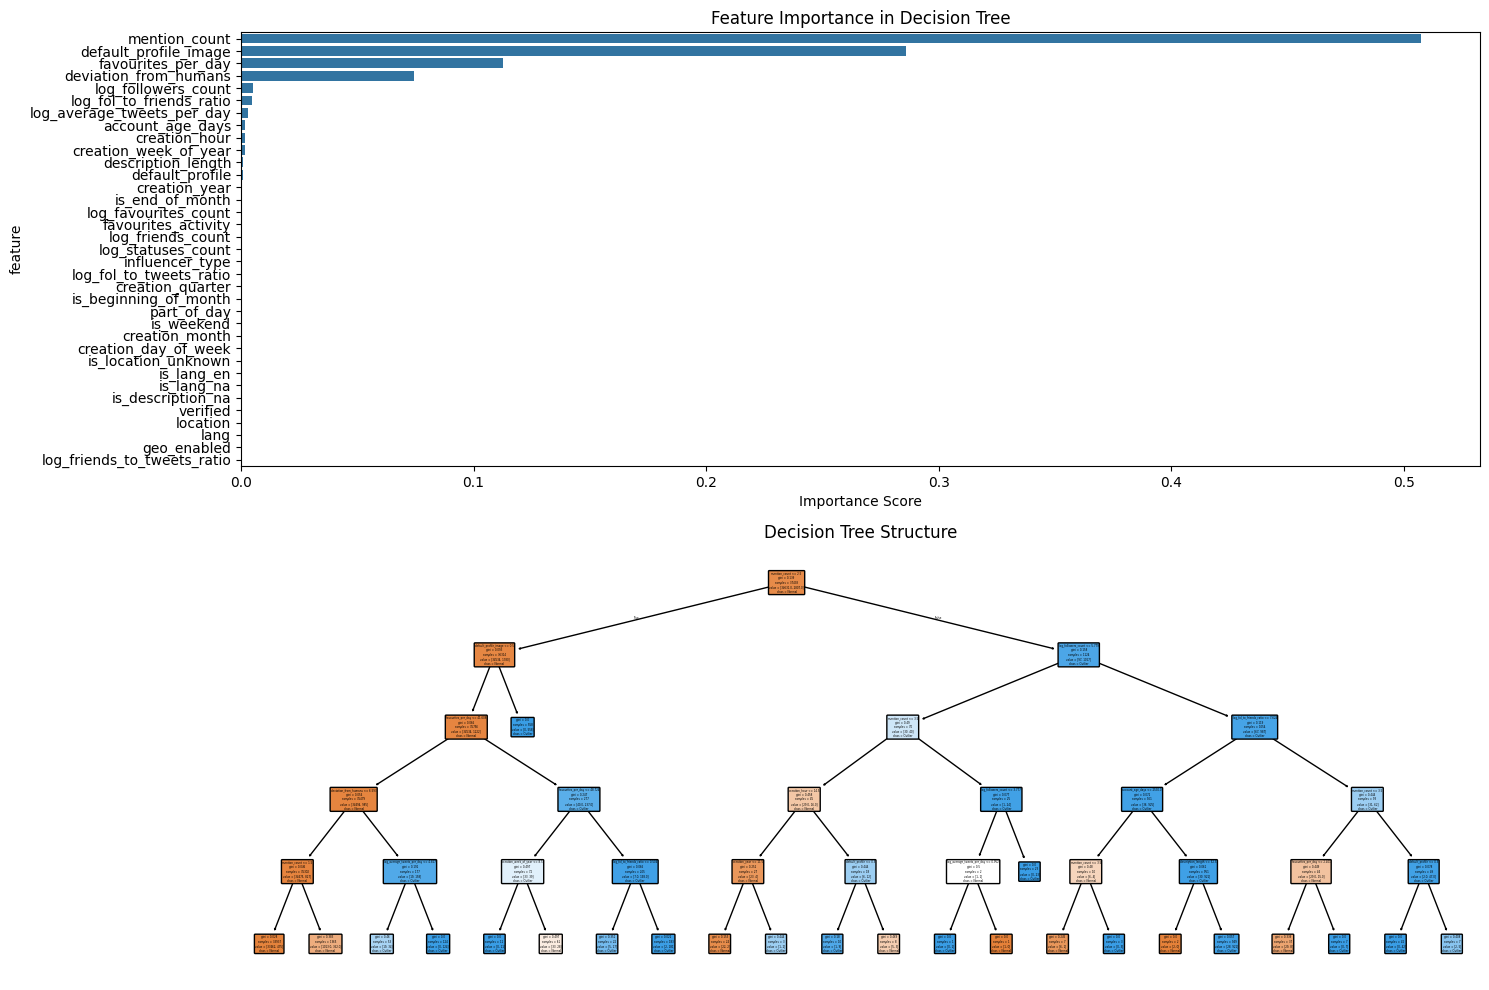


Decision Tree Analysis:

1. Node Statistics:
total_nodes: 47
leaf_nodes: 24
max_depth: 5

2. Feature Threshold Statistics:

mention_count:
  mean: 2.90
  min: 1.50
  max: 3.50
  count: 5

default_profile_image:
  mean: 0.50
  min: 0.50
  max: 0.50
  count: 1

favourites_per_day:
  mean: 30.91
  min: 2.40
  max: 48.72
  count: 3

deviation_from_humans:
  mean: 6.59
  min: 6.59
  max: 6.59
  count: 1

log_average_tweets_per_day:
  mean: 2.89
  min: 0.95
  max: 4.83
  count: 2

creation_week_of_year:
  mean: 8.50
  min: 8.50
  max: 8.50
  count: 1

log_fol_to_friends_ratio:
  mean: 4.06
  min: 0.50
  max: 7.62
  count: 2

log_followers_count:
  mean: 4.78
  min: 3.78
  max: 5.78
  count: 2

creation_hour:
  mean: 14.50
  min: 14.50
  max: 14.50
  count: 1

creation_year:
  mean: 11.50
  min: 11.50
  max: 11.50
  count: 1

default_profile:
  mean: 0.50
  min: 0.50
  max: 0.50
  count: 2

account_age_days:
  mean: 2530.00
  min: 2530.00
  max: 2530.00
  count: 1

description_length:
  mean

In [8]:
# Analyze the surrogate model
df_surrogate = df.copy()
X_surrogate = df_surrogate[ae_cols]

analyze_decision_tree(
    surrogate_model,
    X_surrogate,
    feature_names=ae_cols
)

y_pred = surrogate_model.predict(X_surrogate)
print("\n4. Model Performance:")
print(classification_report(df['account_type'], y_pred))
